In [3]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint as pp
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import pickle

Queries = "topics-2014_2015-summary.topics"
Qrels = "qrels-clinical_trials.txt"
with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title

    
eval = trec.TrecEvaluation(cases, Qrels)
#print(cases.values())
vectorizerQueries = CountVectorizer(ngram_range=(1,1), analyzer = "word", stop_words = None)
YQueries = vectorizerQueries.fit_transform(cases.values())

print("Nr de pacientes (queries): " + str(len(cases)))


Nr de pacientes (queries): 60


## Separação das queries em 2 subsets (treino e teste)

In [4]:
import itertools
def splitDict(d):
    n = len(d) // 5        
    i = iter(d.items()) 

    d1 = dict(itertools.islice(i, n))
    d2 = dict(i)                        
    return d1, d2

#48 queries para treino, 12 para teste
casesTreino , casesTeste = splitDict(cases)

In [8]:
#Fazer load dos ficheiros de ensaios clinicos e ids
def loadFiles():
    docsGender = pickle.load( open( "documentsGender.bin", "rb" ) )
    ids = pickle.load( open( "doc_ids.bin", "rb" ) )
    docMaxAge = pickle.load( open( "docMaxAge.bin", "rb" ) )
    docMinAge = pickle.load( open( "docMinAge.bin", "rb" ) )
    docBriefSummary = pickle.load( open( "documentsSummary.bin", "rb" ) )
    docsTitle = pickle.load( open( "docsTitle.bin", "rb" ) )
    docsDetailed_Description = pickle.load( open( "docsDetailed_Description.bin", "rb" ) )
    return docsGender,ids, docMaxAge, docMinAge, docBriefSummary, docsTitle, docsDetailed_Description
docsGender,ids, docMaxAge, docMinAge, docBriefSummary, docsTitle, docsDetailed_Description = loadFiles()

FileNotFoundError: [Errno 2] No such file or directory: 'docBriefSummary.bin'

In [4]:
#Medias para todas as queries
def calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, nrCases, allRecalls=None):
    averageAllP10s = np.sum(allP10s)/nrCases
    averageAllMrr = np.sum(allMrr)/nrCases
    averageNdcg5 = np.sum(allNdcg5)/nrCases
    averageAp = np.sum(allAp)/nrCases
    if allRecalls:
        averageRecall = np.sum(allRecalls)/nrCases
        return averageAllP10s,averageAllMrr,averageNdcg5, averageAp, averageRecall
    return averageAllP10s,averageAllMrr,averageNdcg5, averageAp

In [5]:
def calculateLMJMValues(matrixTransformed):
    
    #Somar na vertical
    termFreq = matrixTransformed.sum(axis=0)
    #Somar na horizontal
    docLen = matrixTransformed.sum(axis=1)
    #tamanho total do corpus
    lenTotal = np.sum(matrixTransformed)

    #Termos para a formula do LMJM
    termProbabilityAllCorpus = termFreq/lenTotal
    termProbabilityDocument = matrixTransformed.toarray()/docLen

    return termProbabilityAllCorpus, termProbabilityDocument

In [16]:
####### P10
def makeIDP10Graphic(dictCaseIDP10, title, nrXTicks):
    marklist = sorted(dictCaseIDP10.items(), key=lambda x:x[1], reverse = True)
    orderedDictionaryByP10 = dict(marklist)
    xAxisP10Uni = orderedDictionaryByP10.keys()
    yAxisP10Uni = orderedDictionaryByP10.values()
    plt.plot(xAxisP10Uni,yAxisP10Uni)
    plt.xticks(rotation=90)
    plt.xlabel("Case ID")
    plt.ylabel("P10")
    xmarks=[i for i in range(1,nrXTicks+1,5)]
    plt.xticks(xmarks)
    plt.title(title)
    plt.show()

####### Average Precision
def makeIDAPGraphic(dictCaseAP, title, nrXTicks):
    marklist = sorted(dictCaseAP.items(), key=lambda x:x[1], reverse = True)
    orderedDictionaryByAP = dict(marklist)
    xAxisAPUni = orderedDictionaryByAP.keys()
    yAxisAPUni = orderedDictionaryByAP.values()
    plt.plot(xAxisAPUni,yAxisAPUni)
    plt.xticks(rotation=90)
    xmarks=[i for i in range(1,nrXTicks+1,5)]
    plt.xticks(xmarks)
    plt.xlabel("Case ID")
    plt.ylabel("Average Precision")
    plt.title(title)
    plt.show()

###### Precision Recall
def makePrecisionRecall(recall_11point, avg_precision_11point, numberCases, labelGraphic, titleGraphic):
    if labelGraphic:
        plt.plot(recall_11point,avg_precision_11point/numberCases, label =  "Lambda " + labelGraphic)
    else:
        plt.plot(recall_11point,avg_precision_11point/numberCases)
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(titleGraphic)
    plt.show()

###### Precision Recall Unigramas+Bigramas
def makePrecisionRecallUniBig(recall_11pointUni, avg_precision_11pointUni, recall11PointBi, avgPrecision11PointBi, numberCases, melhorLambdaUnigramas, melhorLambdaBigramas, titleGraphic):
    if melhorLambdaUnigramas != None and melhorLambdaBigramas != None:
        plt.plot(recall_11pointUni,avg_precision_11pointUni/numberCases, label = "Unigrama c/ Lambda " + str(melhorLambdaUnigramas))
        plt.plot(recall11PointBi,avgPrecision11PointBi/len(casesTeste), label = "Bigrama c/ Lambda " + str(melhorLambdaBigramas))
    else:
        plt.plot(recall_11pointUni,avg_precision_11pointUni/numberCases, label = "Unigrama")
        plt.plot(recall11PointBi,avgPrecision11PointBi/len(casesTeste), label = "Bigrama")
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(titleGraphic)
    plt.show()

def printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = None):
    print("P10 = " + str(averageAllP10s))
    print("MRR = " + str(averageAllMrr))
    print("NDCG5 = " + str(averageNdcg5))
    print("MAP = " + str(averageAp))
    if averageRecall:
        print("Recall = " + str(averageRecall))


## NGRAMAS DE 1 (Treino)

================= LAMBDA ATUAL: 0.0 ==============
Media dos p10: 0.008333333333333333
Melhor lambda mudou para: 0.0
Media dos p10: 0.008333333333333333
P10 = 0.008333333333333333
MRR = 0.005793103448275861
NDCG5 = 0.02826335043946801
MAP = 0.008356750547317656
MAP = None
================= LAMBDA ATUAL: 0.2 ==============
Media dos p10: 0.13333333333333333
Melhor lambda mudou para: 0.2
Media dos p10: 0.13333333333333333
P10 = 0.13333333333333333
MRR = 0.005793103448275861
NDCG5 = 0.11328429213075776
MAP = 0.08220657796895318
MAP = None
================= LAMBDA ATUAL: 0.4 ==============
Media dos p10: 0.125
P10 = 0.125
MRR = 0.005793103448275861
NDCG5 = 0.10824827453810582
MAP = 0.07997341033348425
MAP = None
================= LAMBDA ATUAL: 0.6 ==============


KeyboardInterrupt: 

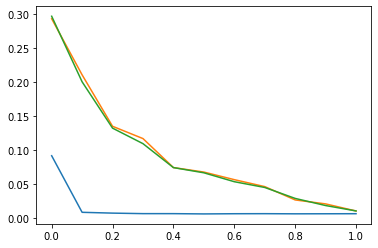

In [13]:

                                    ###### NGRAMAS 1,1 (corpus)
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer = "word", stop_words = None)
vectorizer.fit(docs)
Y = vectorizer.transform(docs)

termProbabilityAllCorpus, termProbabilityDocument = calculateLMJMValues(Y)

#treinar para varios lambdas e escolher tendo em conta as metricas avaliadas
lambdasToTest = np.around(np.arange(0, 1, 0.2),1) 

melhorLambdaUnigramas = 0
bestP10 = 0

for j in lambdasToTest:
    avg_precision_11pointUni = np.zeros(11)
    allP10s,allMrr, allNdcg5, allAp = ([] for i in range(4))
    print("================= LAMBDA ATUAL: " + str(j) + " ==============")
    for caseid in casesTreino: #separar para cases de treino e teste
        query = casesTreino[caseid]
        query_Count= vectorizer.transform([query]).toarray()
  
        PqDc = ((j * termProbabilityDocument) + ((1-j)*termProbabilityAllCorpus)) + 1e-30
        doc_scores = np.log(PqDc)*query_Count.T
        #Calcular os scores para cada ensaio tendo em conta a querie atual
  
        #ids caso clinico, scores para esse ensaio clinico sobre a query corrente
        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        results_ord = results.sort_values(by=['score'], ascending = False)
        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        #Para fazermos a media das metricas (para todas as queries)
        allP10s.append(p10)
        allMrr.append(mrr)
        allNdcg5.append(ndcg5)
        allAp.append(ap)

        [precision_11pointUni, recall_11pointUni, total_relv_ret] = eval.evalPR(results_ord, caseid)
        if (np.shape(recall_11pointUni) != (0,)):
            avg_precision_11pointUni = avg_precision_11pointUni + precision_11pointUni

    mediaP10 = np.average(allP10s)
    if mediaP10 > bestP10:
        bestP10 = mediaP10
        melhorLambdaUnigramas=j
        print("Media dos p10: " + str(mediaP10))
        print("Melhor lambda mudou para: " + str(j))
    print("Media dos p10: " + str(mediaP10))
    
    #Medias para todas as queries
    averageAllP10s, averageAllMrr, averageNdcg5, averageAp = calculateAvgMetrics(allP10s,allMrr,allNdcg5,allAp, len(casesTreino))
    #Metricas para cada lambda
    
    printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp)

    #Plot das curvas para todos os lambdas (para compararmos)
    plt.plot(recall_11pointUni,avg_precision_11pointUni/len(casesTreino), label = "Lambda " + str(j))
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LMJM: Precision/Recall w/ Ngram: 1")
plt.show()

#depois de escolhermos o melhor lambda, usar para o set de teste
print("O melhor lambda é " + str(melhorLambdaUnigramas) + " para unigramas")

## NGRAMAS DE 2 (Treino)

In [ ]:
                                ############ NGRAMAS 2,2
vectorizerBi = CountVectorizer(ngram_range=(2,2), analyzer = "word", stop_words = None)
vectorizerBi.fit(docs)
YBi = vectorizerBi.transform(docs)

termProbabilityAllCorpus, termProbabilityDocument = calculateLMJMValues(YBi)

#for para determinar o melhor lambda tendo em conta as metricas avaliadas la dentro
melhorLambdaBigramas = 0
bestP10 = 0

for j in lambdasToTest:
    allP10s = allMrr = allNdcg5 = allAp = [], [], [], []
    allP10s,allMrr, allNdcg5, allAp = ([] for i in range(4))
    avg_precision_11pointBi = np.zeros(11)
    print("================= LAMBDA ATUAL: " + str(j) + " ==============")
    for caseid in casesTreino:
        queryBi = casesTreino[caseid]
        query_CountBi = vectorizerBi.transform([queryBi]).toarray()

        PqDc = ((j * termProbabilityDocument) + ((1-j)*termProbabilityAllCorpus)) + 1e-30
        #Calcular os scores para cada ensaio tendo em conta a querie atual
        doc_scores = np.log(PqDc)*query_CountBi.T
        
        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        results_ord = results.sort_values(by=['score'], ascending = False)

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        allP10s.append(p10)
        allMrr.append(mrr)
        allNdcg5.append(ndcg5)
        allAp.append(ap)
        
        [precision_11pointBi, recall_11pointBi, total_relv_ret] = eval.evalPR(results_ord, caseid)
        if (np.shape(recall_11pointBi) != (0,)):
            avg_precision_11pointBi = avg_precision_11pointBi + precision_11pointBi
    
    #Dependendo para o melhor p10, o lambda
    mediaP10 = np.average(allP10s)
    if mediaP10 > bestP10:
        bestP10 = mediaP10
        melhorLambdaBigramas=j
        print("Media dos p10: " + str(mediaP10))
        print("Melhor lambda mudou para: " + str(j))
    print("Media dos p10: " + str(mediaP10))
   
    averageAllP10s, averageAllMrr, averageNdcg5, averageAp = calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, len(casesTreino))
    printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp)
    
    #Fazer o plot das curvas para todos os lambdas para bigramas 
    plt.plot(recall_11pointBi,avg_precision_11pointBi/len(casesTreino), label = "Lambda " + str(j))
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LMJM: Precision/Recall w/ Ngram: 2")
plt.show()

#depois de escolhermos o melhor lambda, usar para o set de teste
print("O melhor lambda é " + str(melhorLambdaBigramas) + " para bigramas")

================= LAMBDA ATUAL: 0.0 ==============


MemoryError: Unable to allocate 4.30 GiB for an array with shape (3625, 159295) and data type float64

## TESTE COM O MELHOR LAMBDA (UNIGRAMA)

In [35]:
allP10s,allMrr, allNdcg5, allAp, allRecalls = ([] for i in range(5))
avg_precision_11pointTesteUni = np.zeros(11)

vectorizerUnigramaTeste = CountVectorizer(ngram_range=(1,1), analyzer = "word", stop_words = None)
vectorizerUnigramaTeste.fit(docs)
YUniTeste = vectorizerUnigramaTeste.transform(docs)

termProbabilityAllCorpus, termProbabilityDocument = calculateLMJMValues(YUniTeste)

#So para as queries de teste
for caseid in casesTeste:
    queryUniTeste = casesTeste[caseid]
    query_CountUniTeste = vectorizerUnigramaTeste.transform([queryUniTeste]).toarray()

    PqDc = ((melhorLambdaUnigramas * termProbabilityDocument) + ((1-melhorLambdaUnigramas)*termProbabilityAllCorpus)) + 1e-30
    #Calcular os scores para cada ensaio tendo em conta a querie atual
    doc_scores = np.log(PqDc)*query_CountUniTeste.T
    
    results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)
    
    [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
    allP10s.append(p10)
    allMrr.append(mrr)
    allNdcg5.append(ndcg5)
    allAp.append(ap)
    allRecalls.append(recall)

    [precision_11pointTesteUni, recall_11pointTesteUni, total_relv_ret] = eval.evalPR(results_ord, caseid)
    if (np.shape(recall_11pointTesteUni) != (0,)):
        avg_precision_11pointTesteUni = avg_precision_11pointTesteUni + precision_11pointTesteUni

averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, len(casesTeste), allRecalls)

printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall)

#Plot precision-recall com queries de teste e unigramas
makePrecisionRecall(recall_11pointTesteUni, avg_precision_11pointTesteUni, len(casesTeste), melhorLambdaUnigramas, "LMJM: Precision/Recall w/ Ngram: 1")

AttributeError: 'tuple' object has no attribute 'append'

## Varias seccoes

In [1]:
def LMJMUnigramSection(section, nGram):
    allP10s,allMrr, allNdcg5, allAp, allRecalls = ([] for i in range(5))
    avg_precision_11pointTesteUni = np.zeros(11)

    vectorizerUnigramaTeste = CountVectorizer(ngram_range=(nGram,nGram), analyzer = "word", stop_words = None)
    vectorizerUnigramaTeste.fit(section)
    YUniTeste = vectorizerUnigramaTeste.transform(section)

    termProbabilityAllCorpus, termProbabilityDocument = calculateLMJMValues(YUniTeste)

    #So para as queries de teste
    for caseid in casesTeste:
        queryUniTeste = casesTeste[caseid]
        query_CountUniTeste = vectorizerUnigramaTeste.transform([queryUniTeste]).toarray()

        PqDc = ((melhorLambdaUnigramas * termProbabilityDocument) + ((1-melhorLambdaUnigramas)*termProbabilityAllCorpus)) + 1e-30
        #Calcular os scores para cada ensaio tendo em conta a querie atual
        doc_scores = np.log(PqDc)*query_CountUniTeste.T
        
        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        results_ord = results.sort_values(by=['score'], ascending = False)
        
        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        allP10s.append(p10)
        allMrr.append(mrr)
        allNdcg5.append(ndcg5)
        allAp.append(ap)
        allRecalls.append(recall)

        [precision_11pointTesteUni, recall_11pointTesteUni, total_relv_ret] = eval.evalPR(results_ord, caseid)
        if (np.shape(recall_11pointTesteUni) != (0,)):
            avg_precision_11pointTesteUni = avg_precision_11pointTesteUni + precision_11pointTesteUni

    averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, len(casesTeste), allRecalls)

    printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall)

    #Plot precision-recall com queries de teste e unigramas
    makePrecisionRecall(recall_11pointTesteUni, avg_precision_11pointTesteUni, len(casesTeste), melhorLambdaUnigramas, "LMJM: Precision/Recall w/ Ngram: 1")

    ## Escrever docscores para ficheiro
    pickle.dump(results_ord, open("LMJM_" +  section + "_docscores.bin", "wb" ) )
    #talvez mudar o return caso queiramos as metricas sem ser os docscores
    return results_ord

LMJMUnigramSection(docBriefSummary, 1)

NameError: name 'docBriefSummary' is not defined

## TESTE COM O MELHOR LAMBDA (BIGRAMA)

In [14]:
allP10s,allMrr, allNdcg5, allAp, allRecall = ([] for i in range(5))

avg_precision_11pointTesteBi = np.zeros(11)

vectorizerTesteBi = CountVectorizer(ngram_range=(2,2), analyzer = "word", stop_words = None)
vectorizerTesteBi.fit(docs)
YBiTeste = vectorizerTesteBi.transform(docs)

termProbabilityAllCorpus, termProbabilityDocument = calculateLMJMValues(YBiTeste)

for caseid in casesTeste: #separar para cases de treino e teste
    queryBiTeste = casesTeste[caseid]
    query_CountBiTeste= vectorizerTesteBi.transform([queryBiTeste]).toarray()
    
    PqDc = ((melhorLambdaBigramas * termProbabilityDocument) + ((1-melhorLambdaBigramas)*termProbabilityAllCorpus)) + 1e-30
    doc_scores = np.log(PqDc)*query_CountBiTeste.T
    
    results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)

    [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
    allP10s.append(p10)
    allMrr.append(mrr)
    allNdcg5.append(ndcg5)
    allAp.append(ap)
    allRecall.append(recall)

    [precision_11pointTesteBi, recall_11pointTesteBi, total_relv_ret] = eval.evalPR(results_ord, caseid)
    if (np.shape(recall_11pointTesteBi) != (0,)):
        avg_precision_11pointTesteBi = avg_precision_11pointTesteBi + precision_11pointTesteBi

averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, len(casesTeste), allRecall)

printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall)

#Plot precision-recall com queries de teste e bigramas
makePrecisionRecall(recall_11pointTesteBi, avg_precision_11pointTesteBi, len(casesTeste), melhorLambdaBigramas, "LMJM: Precision/Recall w/ Ngram: 2")

MemoryError: Unable to allocate 4.30 GiB for an array with shape (3625, 159295) and data type float64

In [21]:
#Plot precision-recall para comparar curvas de unigrama e bigrama (Teste)
makePrecisionRecallUniBig(recall_11pointTesteUni, avg_precision_11pointTesteUni, recall_11pointTesteBi, avg_precision_11pointTesteBi, len(casesTeste), melhorLambdaUnigramas, melhorLambdaBigramas, "LMJM: Precision/Recall")

NameError: name 'recall_11pointTesteUni' is not defined

## VECTOR SPACE MODEL (ngrama = 1)

No handles with labels found to put in legend.


P10 = 0.095
MRR = 0.005085057471264367
NDCG5 = 0.09685284857763819
MAP = 0.07184800362407424
Recall = 0.9833333333333333


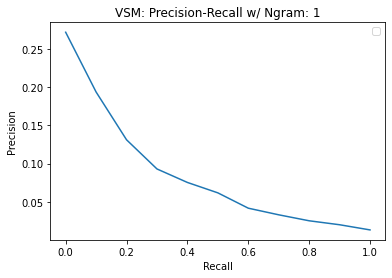

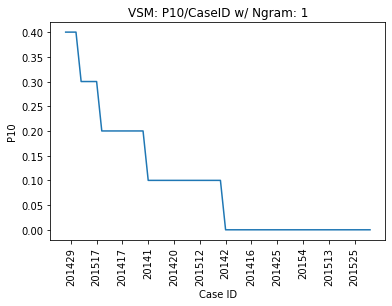

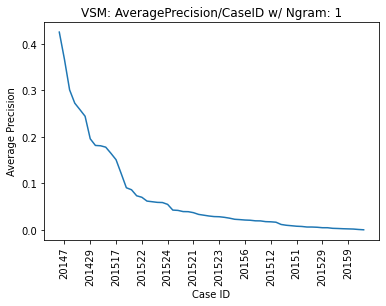

In [15]:
common_stop_words = {"is", "the", "an", "a", "to", "and", "be", "been", "that", "this", "i", "than", "patient", "am", "health", "sick", "clinical"}

vectorizerVSM = TfidfVectorizer(ngram_range=(1,1), analyzer = "word", stop_words = None)
vectorizerVSM.fit(docs)
transformDocsVSM = vectorizerVSM.transform(docs)

allP10s,allMrr, allNdcg5, allAp, allRecall = ([] for i in range(5))
avg_precision_11pointVSMUni = np.zeros(11)
dictCaseIDP10 = dict()
dictCaseAP = dict()

for caseid in cases:
    queryTFIDF = cases[caseid]
    query_CountVSM = vectorizerVSM.transform([queryTFIDF])
    doc_scoresVSM = 1 - pairwise_distances(transformDocsVSM, query_CountVSM, metric="cosine")
  
    #Metricas
    results = pd.DataFrame(list(zip(ids, doc_scoresVSM)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)

    [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
    #Para fazer as medias dos prints
    allP10s.append(p10)
    allMrr.append(mrr)
    allNdcg5.append(ndcg5)
    allAp.append(ap)
    allRecall.append(recall)

    #Para fazer plot de P10-CaseId e AP-Case id (os pacientes com mais matches)
    dictCaseIDP10[caseid] = p10
    dictCaseAP[caseid] = ap

    [precision_11pointVSMUni, recall_11pointVSMUni, total_relv_ret] = eval.evalPR(results_ord, caseid)
    if (np.shape(recall_11pointVSMUni) != (0,)):
        avg_precision_11pointVSMUni = avg_precision_11pointVSMUni + precision_11pointVSMUni

averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, len(cases), allRecall)
printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall)

makePrecisionRecall(recall_11pointVSMUni, avg_precision_11pointVSMUni, len(cases), None, "VSM: Precision-Recall w/ Ngram: 1")
makeIDP10Graphic(dictCaseIDP10, "VSM: P10/CaseID w/ Ngram: 1", 60)
makeIDAPGraphic(dictCaseAP, "VSM: AveragePrecision/CaseID w/ Ngram: 1", 60)


## VECTOR SPACE MODEL (ngrama = 2)

No handles with labels found to put in legend.


P10 = 0.058333333333333334
MRR = 0.005085057471264367
NDCG5 = 0.06751339528433271
MAP = 0.03766675758334426
Recall = 0.9833333333333333


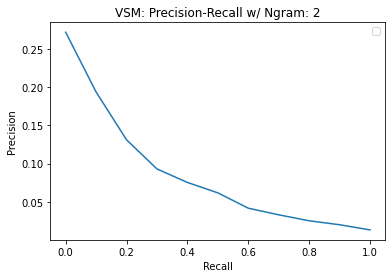

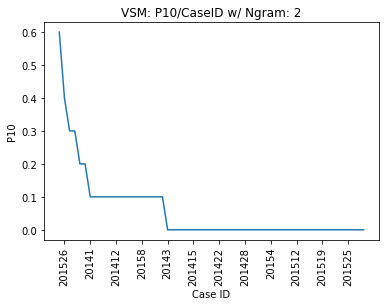

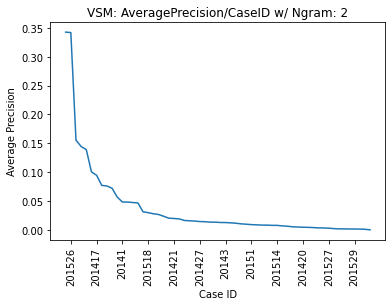

In [18]:
vectorizerVSM = TfidfVectorizer(ngram_range=(2,2), analyzer = "word", stop_words = None)
vectorizerVSM.fit(docs)
transformDocsVSM = vectorizerVSM.transform(docs)

allP10s,allMrr, allNdcg5, allAp, allRecall = ([] for i in range(5))
dictCaseIDP10 = dict()
dictCaseAP = dict()
avg_precision_11pointVSMBi = np.zeros(11)

for caseid in cases: 
    queryTFIDF = cases[caseid]
    query_CountVSM= vectorizerVSM.transform([queryTFIDF])
    doc_scoresVSM = 1 - pairwise_distances(transformDocsVSM, query_CountVSM, metric="cosine")

    #Metricas
    results = pd.DataFrame(list(zip(ids, doc_scoresVSM)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)

    [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
    allP10s.append(p10)
    allMrr.append(mrr)
    allNdcg5.append(ndcg5)
    allAp.append(ap)
    allRecall.append(recall)

    dictCaseIDP10[caseid] = p10
    dictCaseAP[caseid] = ap

    [precision_11pointVSMBi, recall_11pointVSMBi, total_relv_ret] = eval.evalPR(results_ord, caseid)
    if (np.shape(recall_11pointVSMBi) != (0,)):
        avg_precision_11pointVSMBi = avg_precision_11pointVSMBi + precision_11pointVSMBi


averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, len(cases), allRecall)
printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall)

makePrecisionRecall(recall_11pointVSMUni, avg_precision_11pointVSMUni, len(cases), None, "VSM: Precision-Recall w/ Ngram: 2")
#ID-P10 & ID-AP Graphics
makeIDP10Graphic(dictCaseIDP10, "VSM: P10/CaseID w/ Ngram: 2", 60)
makeIDAPGraphic(dictCaseAP, "VSM: AveragePrecision/CaseID w/ Ngram: 2", 60)

## Gráficos VSM Juntos

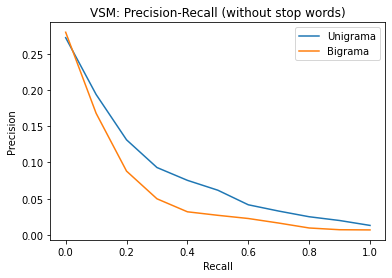

In [19]:
################# PRECISION RECALL ##############
makePrecisionRecallUniBig(recall_11pointVSMUni,avg_precision_11pointVSMUni,recall_11pointVSMBi,avg_precision_11pointVSMBi, len(cases), None, None, "VSM: Precision-Recall (without stop words)")